*Copied from `edge_and_node.ipynb`:*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numba

import scipy.sparse as sparse
import scipy.io as io

import tskit as ts
import msprime

import sys
from tsblup.operations import *
from tsblup.matrices import *
# from tsblup.simulations import *

In [2]:
###### sim ancestry
ts = msprime.sim_ancestry(
    samples=10,
    recombination_rate=1e-8,
    sequence_length=1_000,
    population_size=10_000,
    random_seed=100,
)

###### chunck edges to have unique descendant nodes
ts = split_upwards(ts)

In [3]:
##### edge-based matrices
E_edge = edge_adjacency(ts).T # transpose to make A upper triangular
Z_edge = edge_individual_matrix(ts).T
D_edge = (ts.edges_right - ts.edges_left) * (ts.nodes_time[ts.edges_parent] - ts.nodes_time[ts.edges_child])

In [4]:
assert E_edge.shape == (ts.num_edges, ts.num_edges)
assert Z_edge.shape == (ts.num_individuals, ts.num_edges)
assert D_edge.shape == (ts.num_edges, )
assert (E_edge.min(), E_edge.max()) == (0.0, 1.0)

In [5]:
for t in ts.trees():
    for n in t.nodes():
        p = t.parent(n)
        if p != tskit.NULL:
            en = t.edge(n)  # edge ID
            ep = t.edge(p)
            if ep != tskit.NULL:
                assert E_edge[en, ep] == 1.0

In [6]:
sigma = 0.3
nE = ts.num_edges
nI = ts.num_individuals
n = nE + nI
M = np.zeros((n, n), dtype='float')
Dinv = np.diag(1/D_edge)
Dinvsqrt = np.diag(1 / np.sqrt(D_edge))
Dsqrt = np.diag(np.sqrt(D_edge))
T = np.linalg.inv(np.eye(ts.num_edges) - E_edge)
M[:nE, :nE] = T @ Dsqrt
M[:nE, nE:] = 0
M[nE:, :nE] = Z_edge.toarray()
M[nE:, nE:] = sigma * np.eye(nI)

In [7]:
Sigma = M @ (M.T)
Q = np.linalg.inv(Sigma)

In [14]:
Minv = np.linalg.inv(M)
Minv2 = np.zeros(Minv.shape)
Minv2[:nE, :nE] = Dinvsqrt @ (np.eye(nE) - E_edge)
Minv2[nE:, nE:] = np.eye(nI) / sigma
Minv2[nE:, :nE] = (-1/sigma) * Z_edge @ Dinvsqrt @ (np.eye(nE) - E_edge)
assert np.max(np.abs(Minv - Minv2)) < 1e-8

In [15]:
assert np.max(np.abs(Q - Minv.T @ Minv)) < 1e-8

In [18]:
y = np.arange(ts.num_individuals)
# Q matrix expression
cond_mean_1 = - np.linalg.inv(Q[:nE,:nE]) @ Q[:nE, nE:] @ y
# Sigma matrix expression
cond_mean_2 = Sigma[:nE,nE:] @ np.linalg.inv(Sigma[nE:,nE:]) @ y
np.max(np.abs(cond_mean_1 - cond_mean_2))

1.1309566616546363e-08

In [20]:
# manipulated expression
S = np.eye(nE) + (1 / sigma**2) * (Z_edge.T @ Z_edge)
cond_mean_3 = (1/sigma**2) * T @ Dsqrt @ np.linalg.inv(S) @ Z_edge.T @ y
np.max(np.abs(cond_mean_1 - cond_mean_3))

1.1314114090055227e-08

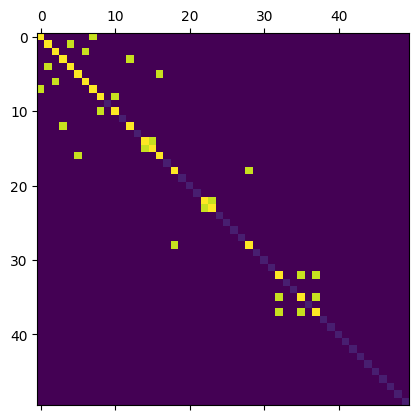

In [23]:
import matplotlib.pyplot as plt

plt.matshow(S);

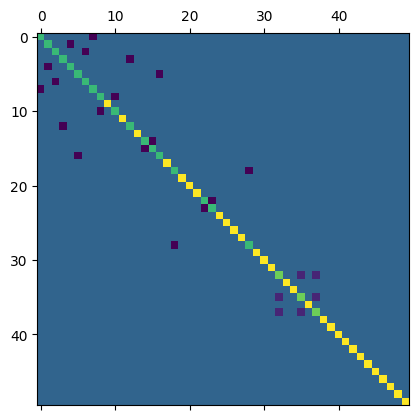

In [38]:
plt.matshow(np.linalg.inv(S))